# ID3 Classifier

## Dataset Configuration
Code taken and adjusted from the lab. We import the train and test data from the keras imdb dataset, converting it to the necessary format for the model.

In [1]:
m = 2000   # Number of words in the vocabulary
n = 65     # N most frequent words to skip
k = 0      # K least frequent words to skip

In [2]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Converts the dataset data into a binary vector, where each word is represented by a 1 or 0. 1 if the word is present in the review, 0 if it is not.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())

X is a matrix of vectors (reviews) where each vector is a binary vector representing the words in the review. 
Y is a vector of labels (0 or 1) where 0 is a negative review and 1 is a positive one.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from seaborn import heatmap
from pandas import DataFrame
import IPython.display as ipd


def classification_data(estimator, 
                          x_train, y_train,
                          x_test, y_test,
                          splits = 5):
  """
  Trains a model on a training set and evaluates it on both the 
  training and test sets for a given number of splits. Calculates
  the accuracy, precision, recall and F1 score for each split as
  well as the final confusion matrix.  
  
  Arguments:
    estimator obj: The model to be trained and evaluated
    x_train, x_test: The binary training and test data. 
    y_train, y_test: The training and test labels (0 or 1). 
    n_splits: The number of splits to use for training.
  Returns: 
    A dictionary containing the train/test accuracies, precisions,
    recalls and F1 scores as well as the final confusion matrix.
  """

  train_accuracies, test_accuracies, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  # Split the training data into n splits
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  test_cm = None
  
  # Train the model on each split and evaluate on the test set
  for i in range(0, len(x_splits)):
    if i == 0:
      curr_x = x_splits[0]
      curr_y = y_splits[0]
    else:
      curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
      curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    # Train the model and get train/test predictions
    estimator.fit(curr_x, curr_y)
    train_pred = estimator.predict(curr_x)
    test_pred = estimator.predict(x_test)
    
    # Calculate and save the necessary metrics for this train/test split
    train_accuracies.append(accuracy_score(curr_y, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))
    
    train_precisions.append(precision_score(curr_y, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    train_recall.append(recall_score(curr_y, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    train_f1.append(f1_score(curr_y, train_pred))
    test_f1.append(f1_score(y_test, test_pred))
  
  # Calculate the final confusion matrix
  cm = confusion_matrix(y_test, test_pred)
  
  
  # Results required for all the future plots/tables
  return {'estimator': estimator.__class__.__name__, 
          'split_size': split_size, 
          'splits': splits,
          'test_predictions': test_pred,
          'train_accuracy': train_accuracies, 
          'test_accuracy': test_accuracies, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1,
          'final_cm': cm}
  
  
def classification_cm_heatmap(cm, title):
    """
    Creates a heatmap of the confusion matrix.  
    
    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns: 
      A heatmap of the confusion matrix.
    """
    
    
    cm_matrix = DataFrame(data=cm, columns=['Predict Negative: 0', 'Predicted Positive: 1'],
                          index=['Actual Negative: 0', 'Actual Positive: 1'])
    ax = plt.axes()
    ax.set_title('Confusion Matrix Heatmap for {title}'.format(title=title))
    return heatmap(cm_matrix, annot=True, fmt='d')
  
  
def classification_table(classification_data):
  """
  Creates a table of the train/test accuracies, precisions, recalls
  and F1 scores for each split.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
  Returns: 
    A dataframe table of the train/test accuracies, precisions, recalls and F1 scores
  """
    
  split_size = classification_data['split_size']
  df = DataFrame(data={'Train Accuracy': np.round(classification_data['train_accuracy'], 2), 
                         'Test Accuracy': np.round(classification_data['test_accuracy'], 2), 
                         'Precision Train' : np.round(classification_data['train_precision'], 2), 
                         'Precision Test' : np.round(classification_data['test_precision'], 2), 
                         'Recall Train' : np.round(classification_data['train_recall'], 2), 
                         'Recall Test' : np.round(classification_data['test_recall'], 2), 
                         'F1 Train' : np.round(classification_data['train_f1'], 2), 
                         'F1 Test' : np.round(classification_data['test_f1'], 2)}, 
                   index=list(range(split_size, len(x_train) + split_size, split_size)))
  return df


def classification_plots(classification_data, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores.
  """
  
  split_size = classification_data['split_size']
  splits = classification_data['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve for {estimator}".format(estimator=classification_data['estimator']), fontsize=16)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training")
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing")
      axis[i, j].grid(alpha = 0.3)  
  
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
 
  return figure


def classification_plots_compare(classification_data_x, classification_data_y, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure for both classifiers.
  
  Arguments:
    classification_data_x: The dictionary containing the train/test data for the first classifier.
    classification_data_y: The dictionary containing the train/test data for the second classifier.
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores 
    for both classifiers.
  """
  
  split_size = classification_data_x['split_size']
  splits = classification_data_x['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve Comparison for {estimator} against {estimator_2} ".format(estimator=classification_data_x['estimator'], estimator_2=classification_data_y['estimator']), fontsize=12)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#AD49C2", label="Training {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#7CC249", label="Testing {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].grid(alpha = 0.3) 
    
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
  return figure

## ID3 Classifier Implementation
A class that implements ID3 for binary classification. The class has two methods: fit and predict. 
The fit method takes in a list of binary vectors and a list of labels and trains the classifier. 
The predict method takes in a list of binary vectors and returns a list of labels.

In [5]:
import random

# if node is parent node , it will have: 1)the feature with the maximum Information Gain 2)right child 3)left child (each child can be either a subtree or a leaf)
# if node is leaf it will only have the pred which is the decision either good or bad (1 or 0)
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = -1 
        self.pred = -1


class ID3:

    def __init__(self,maxDepth):
        self.root = Node()
        self.maxDepth = maxDepth

    def IG(self,class_, feature):
        classes = set(class_)
        feature_values = set(feature)
        Hc = 0
        for c in classes:
            pc = list(class_).count(c)/len(class_)
            Hc += - pc * log(pc, 2)
        Hc_feature = 0
        for feat in feature_values:
            #pf --> P(X=x)
            pf = list(feature).count(feat)/len(feature)
            indices = [i for i in range(len(feature)) if feature[i] == feat] 
            clasess_of_feat = [class_[i] for i in indices] 
            for c in classes: #c=0,1
                #pcf --> P(C=c|X=x)
                pcf = clasess_of_feat.count(c)/len(clasess_of_feat) 
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * log(pcf, 2)
                    #sum for all values of C (class) and X (values of specific feature)
                    Hc_feature += temp_H
        ig = Hc - Hc_feature
        return ig 


    def ID3_TREE(self,X,y,list_features,depth):
    
        root = Node()
        left_y = list() 
        right_y = list()
        left_subdata = list()
        right_subdata= list()
        X_new = np.array(X)
        max_IG = -1
        feature_max_IG = -1
        
        # finds the feature with the maximum Information Gain
        for i in range(len(X[0])):
            feat_ig = self.IG(y,X_new[:,i])
            if max_IG < feat_ig:
                max_IG = feat_ig
                local_indexofFeature_maxIG = i
                feature_max_IG = list_features[i]
        root.feature = feature_max_IG
        # delete the feature with the maximum IG from the feature list
        list_features_del = np.delete(list_features,local_indexofFeature_maxIG)
        # delete the row from array X_new which has the feature with the maximum IG
        X_new = np.delete(X_new,local_indexofFeature_maxIG,1) 

        # split the data in two lists
        # for each example if the feature with the maximum IG == 0 append this example in list0 and in y_new0 append the classification (Good(1) or Bad(0)) of this example
        # else if the feature with the maximum IG == 1  append this example in list1 and in y_new1 append the classification (Good(1) or Bad(0)) of this example
        for i in range(len(X)): 
            if X[i][local_indexofFeature_maxIG]== 0:  
                left_y.append(y[i]) 
                left_subdata.append(X_new[i])
            else: 
                right_y.append(y[i])
                right_subdata.append(X_new[i])  
        
        subdata_X = [left_subdata,right_subdata] 
        subdata_y = [left_y,right_y]
         
        #this loop create the left and right child of Node root 
        for i in range(2): 
            sum_of_positive_examples= np.sum(subdata_y[i])
            # if the percentage of positive(1) examples is greater than 80% or the percentage of negative(0) examples is greater than 80% or we reach in maxdepth
            #  then create leaf and take decision (positive or negative example) 
            if sum_of_positive_examples>=0.8*len(subdata_y[i]) or sum_of_positive_examples<0.2*len(subdata_y[i]) or  depth==self.maxDepth:
                new_Node = Node()
                if (depth==self.maxDepth):
                    if(sum_of_positive_examples>(len(subdata_y[i])/2)):
                        new_Node.pred = 1
                    elif sum_of_positive_examples<(len(subdata_y[i])/2):
                        new_Node.pred = 0      
                    else:
                        new_Node.pred = random.randint(0, 1)      
                else:
                    if(sum_of_positive_examples>=0.8*len(subdata_y[i])):    
                        new_Node.pred = 1 
                    else:
                        new_Node.pred = 0 

                if i==0 :
                    root.left = new_Node   
                else:
                    root.right = new_Node   
            else:
                #when i == 0 create the left subtree, when i == 1 create the right subtree
                child = self.ID3_TREE(subdata_X[i], subdata_y[i],list_features_del,depth+1)
                if i==0 :
                    root.left = child   
                else:
                    root.right = child
        return root 

    def fit(self, X, y):
        list_features =np.arange(len(X[0]))
        self.root = self.ID3_TREE(X, y, list_features, 0)
        
    def predict(self, X): 
        root=Node()
        y_pred = list()
        for example in X:
            root = self.root
            for i in range(len(example)):
                if root.left == None and root.right == None:
                    y_pred.append(int(root.pred))
                    break
                if example[root.feature] == 0:
                    root = root.left
                else:
                    root = root.right            
               
        return y_pred  

## ID3 Classifier Results and Comparison
The ID3 for Classification is tested on the test data and the results are visualized. The results are compared to the results of other relevant classifiers from the SKLearn library.

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     12500
           1       0.70      0.83      0.76     12500

    accuracy                           0.73     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.74      0.73      0.73     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.76,0.71,0.72,0.67,0.87,0.83,0.79,0.74
10000,0.75,0.73,0.71,0.68,0.88,0.85,0.78,0.76
15000,0.75,0.73,0.71,0.70,0.84,0.82,0.77,0.75
20000,0.75,0.73,0.71,0.69,0.87,0.84,0.78,0.76
25000,0.74,0.73,0.70,0.70,0.85,0.83,0.77,0.76


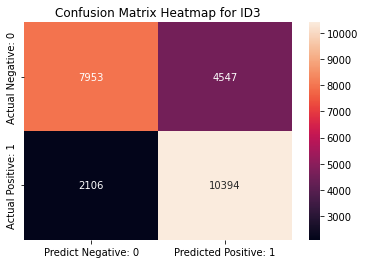

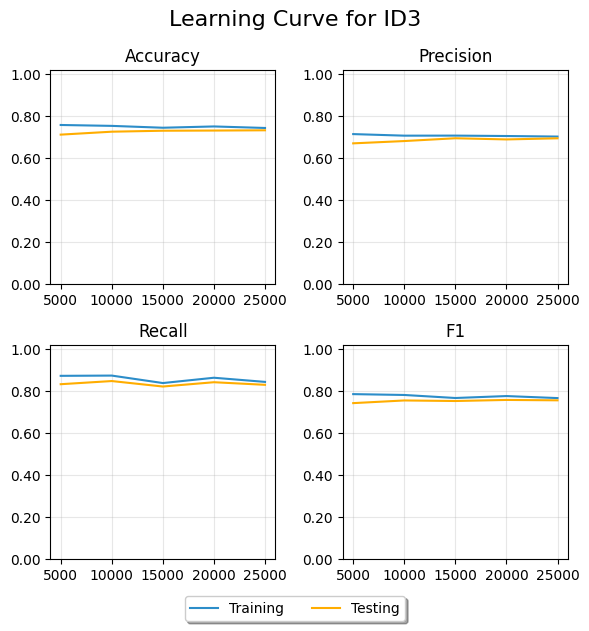

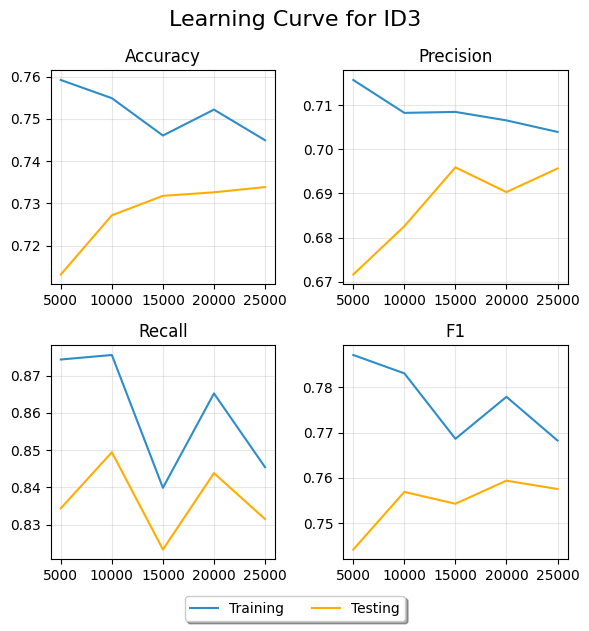

In [6]:
ID3_data = classification_data(ID3(10), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, ID3_data['test_predictions']))
ID3_cf_hmp = classification_cm_heatmap(ID3_data['final_cm'], ID3_data['estimator'])
ID3_cf_tbl = classification_table(ID3_data)
ipd.display(ID3_cf_tbl)

ID3_cf_tplt = classification_plots(ID3_data,True)
ID3_cf_fplt = classification_plots(ID3_data)

### ID3 against SKLearn's DecisionTreeClassifier
The ID3 implementation is tested against the SKLearn DecisionTreeClassifier, also using the entropy function. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.020000,0.010000,-0.020000,0.010000,-0.010000,0.020000,-0.010000,0.010000
10000,-0.020000,0.020000,0.000000,0.010000,-0.020000,0.000000,-0.020000,0.010000
15000,-0.010000,0.010000,0.010000,0.030000,-0.050000,-0.030000,-0.010000,0.000000
20000,-0.010000,0.010000,0.010000,0.020000,-0.020000,-0.010000,0.000000,0.010000
25000,-0.020000,0.000000,0.000000,0.020000,-0.030000,-0.020000,-0.010000,0.000000


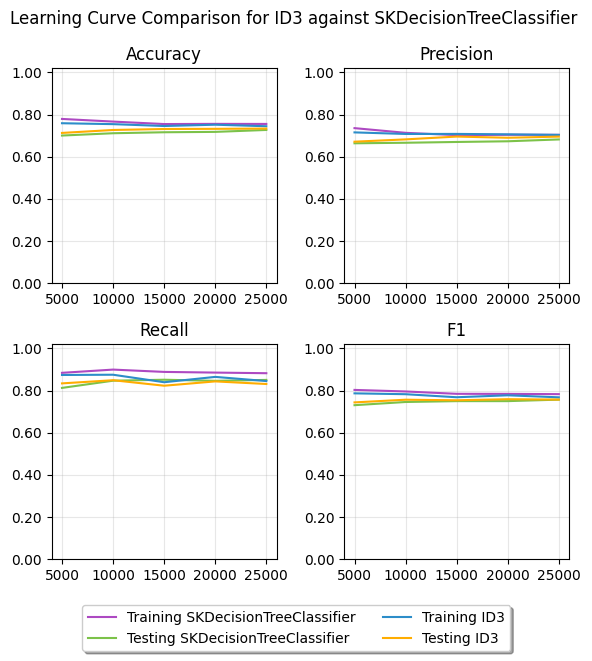

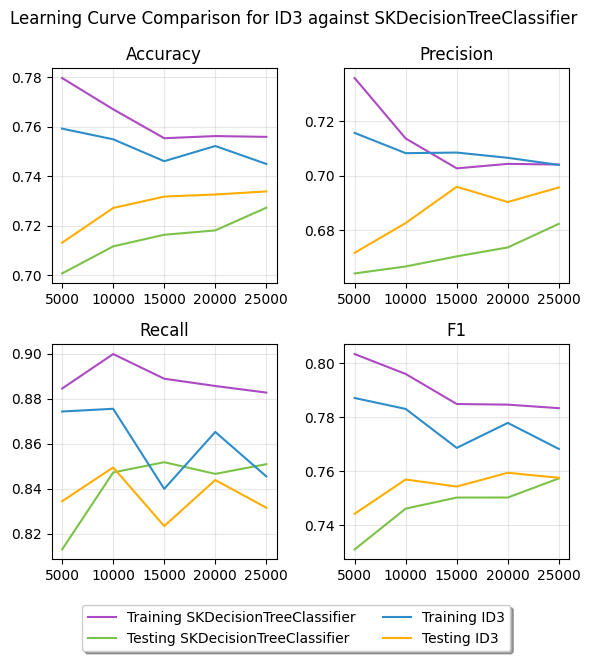

In [7]:
from sklearn.tree import DecisionTreeClassifier

skDT_data = classification_data(DecisionTreeClassifier(criterion='entropy', max_depth=10), x_train_binary, y_train, x_test_binary, y_test, 5)
skDT_data['estimator'] = 'SKDecisionTreeClassifier'
#skDT_cf_hmp = classification_cm_heatmap(skDT_data['final_cm'], skDT_data['estimator'])
skDT_cf_tbl = classification_table(skDT_data)
ID3_skDT_tbl = ID3_cf_tbl - skDT_cf_tbl
ID3_skDT_tbl = ID3_skDT_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=ID3_data['estimator'], estimator_2=skDT_data['estimator']))
ipd.display(ID3_skDT_tbl)

IDE_skDT_tplt = classification_plots_compare(ID3_data, skDT_data, True)
IDE_skDT_fplt = classification_plots_compare(ID3_data, skDT_data)

### ID3 against SKLearn's Bernoulli Naive Bayes
The ID3 implementation is tested against the SKLearn Bernoulli Naive Bayes Classifier. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.100000,-0.130000,-0.140000,-0.170000,0.000000,-0.010000,-0.070000,-0.100000
10000,-0.110000,-0.110000,-0.140000,-0.160000,0.010000,0.000000,-0.080000,-0.080000
15000,-0.100000,-0.110000,-0.140000,-0.140000,-0.020000,-0.030000,-0.080000,-0.090000
20000,-0.100000,-0.110000,-0.140000,-0.150000,0.010000,0.000000,-0.070000,-0.080000
25000,-0.110000,-0.110000,-0.140000,-0.140000,-0.010000,-0.020000,-0.080000,-0.080000


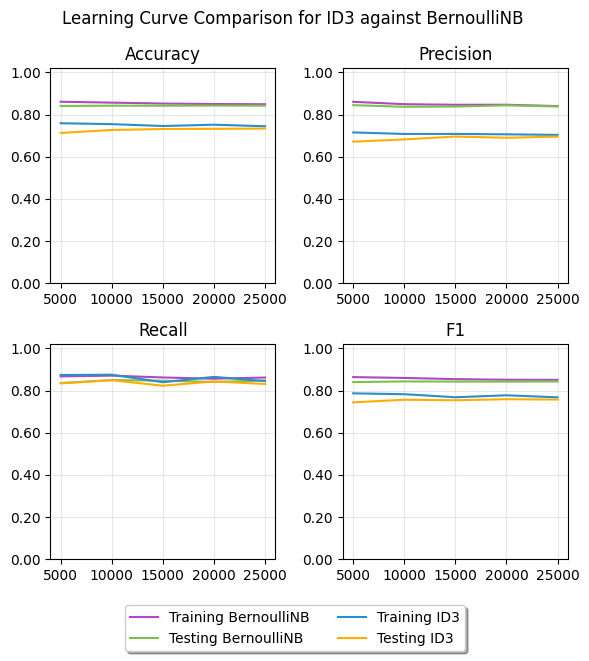

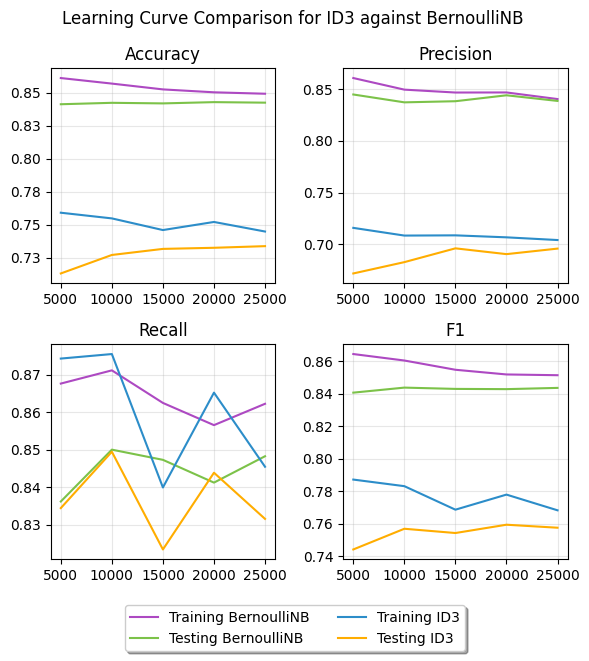

In [8]:
from sklearn.naive_bayes import BernoulliNB

skbnb_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
# skbnb_cf_hmp = classification_cm_heatmap(skbnb_data['final_cm'], skbnb_data['estimator'])
skbnb_cf_tbl = classification_table(skbnb_data)
ID3_skbnb_tbl = ID3_cf_tbl - skbnb_cf_tbl
ID3_skbnb_tbl = ID3_skbnb_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=ID3_data['estimator'], estimator_2=skbnb_data['estimator']))
ipd.display(ID3_skbnb_tbl)

ID3_skbnb_tplt = classification_plots_compare(ID3_data, skbnb_data, True)
bnb_skbnb_fplt = classification_plots_compare(ID3_data, skbnb_data)

### ID3 against SKLearn's SGDC Classifier

The ID3 Classifier is tested against the SKLearn SGDC Classifier. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.240000,-0.100000,-0.270000,-0.140000,-0.130000,0.020000,-0.210000,-0.070000
10000,-0.190000,-0.110000,-0.240000,-0.170000,-0.040000,0.030000,-0.160000,-0.070000
15000,-0.160000,-0.120000,-0.190000,-0.140000,-0.090000,-0.050000,-0.140000,-0.100000
20000,-0.160000,-0.130000,-0.200000,-0.170000,-0.040000,-0.010000,-0.130000,-0.100000
25000,-0.160000,-0.130000,-0.190000,-0.150000,-0.060000,-0.040000,-0.130000,-0.100000


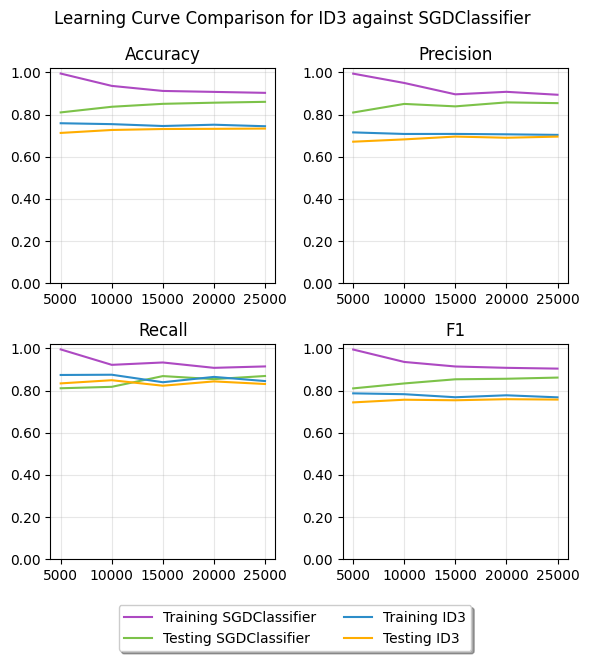

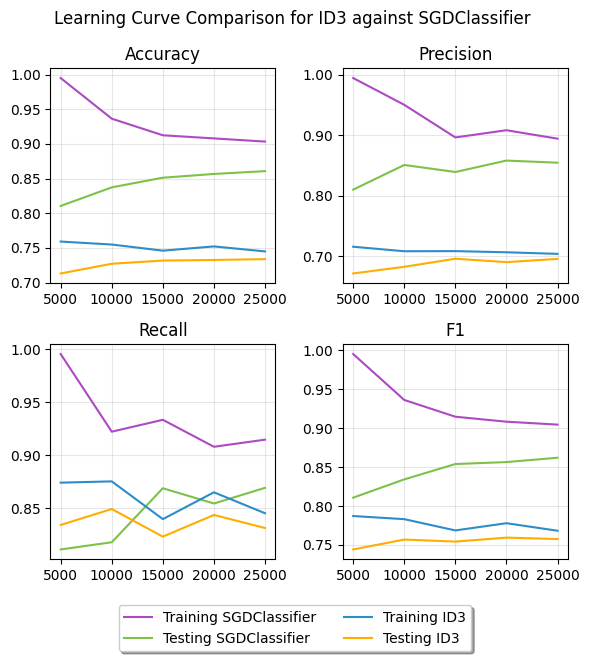

In [9]:
from sklearn.linear_model import SGDClassifier

sklogreg_data = classification_data(SGDClassifier(loss="log_loss"), x_train_binary, y_train, x_test_binary, y_test, 5)
# sklogreg_cf_hmp = classification_cm_heatmap(sklogreg_data['final_cm'], sklogreg_data['estimator'])
sklogreg_cf_tbl = classification_table(sklogreg_data)
ID3_sklogreg_tbl = ID3_cf_tbl - sklogreg_cf_tbl
ID3_sklogreg_tbl = ID3_sklogreg_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=ID3_data['estimator'], estimator_2=sklogreg_data['estimator']))
ipd.display(ID3_sklogreg_tbl)

ID3_sklogreg_tplt = classification_plots_compare(ID3_data, sklogreg_data, True)
ID3_sklogreg_fplt = classification_plots_compare(ID3_data, sklogreg_data)